# UKOOA-2-CSV
### The main purpose of this notebook is to create an easier way of handling UKOOA (and other) navigation files for loading 2D seismic into geoscience software.
### Posted a discussion in #open-geoscience in SWUNG and thanks to Matt Hall [agile] for coming in big for laying a great foundation. If you don't want to fuss with the gdal/ogr dependency, check his version.

<br>**Discussion: https://swung.slack.com/archives/C0AG7T5UP/p1593723082091000**
<br> **Matt's version: https://github.com/agile-geoscience/gio/blob/master/notebooks/Read_UKOOA_UKA_navigation_file.ipynb**
<br>**Standards for UKOOA (1990) are here (there is a newer version out) >> https://www.iogp.org/wp-content/uploads/2016/12/P1.pdf**
<br>**GDAL library link for vector drives including SEGUKOOA are here >> https://gdal.org/drivers/vector/segukooa.html**

<br> *Disclaimer: I have not thoroughly tested other formats other than .UKA. As I use this more, I will make sure to include the other formats as I cross them. The idea is to include .SP1, etc.*
<br><br> Phillip Bailey | July 2020 

In [1]:
import os
import glob
import gdal
import ogr

In [2]:
os.chdir("./data") # if you wanted to place all of the navigation files together in a sub-directory

In [3]:
driver = ogr.GetDriverByName("SEGUKOOA")

In [4]:
def ogr_ukooa_check():
    '''
    Function serves to find navigation files with certain file extensions within directory called above
    (otherwise it will look in current directory). Save files that match extensions in list. 
    Iterate through list, opening each file using gdal driver and performing quick check on the files to ensure gdal
    can read the file correctly.
    '''
    nav_ftypes = ("*.UKA", "*.UKO", "*.SP1")
    nav_flist = []
    for file in nav_ftypes:
        nav_flist.extend(glob.glob(file))
    print (f'Number of seismic navigation files in dir: {len(nav_flist)}\n')
    
    i = 0
    while i < len(nav_flist):
        ds = driver.Open(nav_flist[i])
        if ds is None:
            print (f'Cannot open {nav_flist[i]} dataset')
            return 'fail'
        if ds.GetLayerCount() != 2:
            print (f'Incorrect layer count for {nav_flist[i]}')
            return 'fail'
        lyr = ds.GetLayer(0)
        if lyr.GetGeomType() != ogr.wkbPoint:
            print (f'Incorrrect layer geometry type for {nav_flist[i]}')
            return 'fail'
        ds = None
        print (" %i) " %i,nav_flist[i])
        i = i + 1
    return 'Success'

In [5]:
ogr_ukooa_check()

Number of seismic navigation files in dir: 6

 0)  BP882D1009.UKA
 1)  PON14_SH822D1001.UKA
 2)  PON14_BP862D1004.UKA
 3)  PON14_BP882D1009.UKA
 4)  PON14_BO832D0002.UKA
 5)  PON14_BP832D2007.UKA


'Success'

## Take a quick look at the file headers
(Copy/Paste using the filename printed above. Note the datum/projection if given for later step.)

In [109]:
!head -20 'PON14_BO832D0002.UKA'

H0100 Survey Area               BN27                                            
H0103 Source Details            Unknown                                         
H0200 Date of survey            1983                                            
H0202 Tape Version              UKOOA P1/90                                     
H0300 Details of Client         BRITOIL PUBLIC LIMITED COMPANY                  
H0400 Geophysical Contractor    GECO                                            
H1400 Coordinate location       Unknown                                         
H1500 Geodetic datum as plotted ED50       INTERNAT1924                         
H2600 Exported from DTI 2D database and loaded to CDA database in 2000.         
ZCNS-83-112           101573434.90N  0 4 9.90W                                  
ZCNS-83-112           200573547.80N  0 316.10W                                  
ZCNS-83-112           3005737 2.90N  0 214.40W                                  
ZCNS-83-112           400573

## Gdal's SEGUKOOA driver looks for data in each of the following attributes per the standard.

* **LINENAME**
* VESSEL_ID
* SOURCE_ID
* OTHER_ID
* **POINTNUMBER** (Shotpoints)
* **LONGITUDE**
* **LATITUDE**
* EASTING
* NORTHING
* DEPTH
* DAYOFYEAR
* TIME
* DATETIME

*Note: In bold are the attributes this tool uses but you can check the other attributes and if the have valid information using the code below.* 
<br>**Change cells from Markdown to code for use.**

ds = driver.Open('PON14_BP832D2007.UKA')
lyr = ds.GetLayer(0)
layerDefinition = lyr.GetLayerDefn()
for i in range(layerDefinition.GetFieldCount()):
    fieldName =  layerDefinition.GetFieldDefn(i).GetName()
    fieldTypeCode = layerDefinition.GetFieldDefn(i).GetType()
    fieldType = layerDefinition.GetFieldDefn(i).GetFieldTypeName(fieldTypeCode)
    fieldWidth = layerDefinition.GetFieldDefn(i).GetWidth()
    GetPrecision = layerDefinition.GetFieldDefn(i).GetPrecision()

    print (fieldName + " - " + fieldType+ " " + str(fieldWidth) + " " + str(GetPrecision))

lyr.SetAttributeFilter("LINENAME = '83-622'") # for easier reading...selecting one line
n_feat = 0
for feature in lyr:
    print(feature.GetField('LINENAME'),feature.GetField('VESSEL_ID'),feature.GetField('SOURCE_ID'),feature.GetField('OTHER_ID'),feature.GetField('EASTING'),feature.GetField('NORTHING'),feature.GetField('DEPTH'),feature.GetField('DAYOFYEAR'),feature.GetField('TIME'),feature.GetField('DATETIME'))
    n_feat += 1
    if n_feat == 10:
        break

lyr.ResetReading()

### Other helpful gdal/ogr commands to inspect file before moving forward.

**check which functions are permitted with dataset**
geom = feature.GetGeometryRef()
for m in dir ( geom ):
    if m[0].isupper():
        print (m)
        
**check epsg spatial reference system used for file**
srs = lyr.GetSpatialRef()

## Open one file at a time by copy/paste filenames above into code below.
#### Results will include a csv, pandas dataframe and geopandas geodataframe of line name, shotpoints, longitude, latitude. CSV formatted files can be used as "world coordinate" imports in geoscience software for 2D seismic loading. (*if the X/Y's are not in the segy file)*.

In [110]:
ds = None
filename = "PON14_BO832D0002"
data_in = filename + ".UKA"
ds = driver.Open(data_in)
lyr = ds.GetLayer(0)

In [68]:
import numpy as np

In [111]:
geom_list = []
for feature in lyr:
    lon = feature.GetField("LONGITUDE")
    lat = feature.GetField("LATITUDE")
    geom_list.append(lon)
    geom_list.append(lat)
lons = geom_list[0::2]
lats = geom_list[1::2]
coords = zip(lons,lats)
xys = np.array([(lon, lat) for lon, lat in coords])

lyr.ResetReading()

sp_list = []
for feature in lyr:
    line_name = feature.GetField("LINENAME")
    sp = feature.GetField("POINTNUMBER")
    sp_list.append(line_name)
    sp_list.append(sp)
line = sp_list[0::2]
# lines = np.array([(line) for line in line])
sp = sp_list[1::2]
# sps = np.array([(sp) for sp in sp])
seis_details = zip(line,sp)
seis_info = np.array([(line, sp) for line, sp in seis_details])
# print(lines,sps)

In [112]:
compiled = np.concatenate((seis_info, xys), axis=1)

In [71]:
import pandas as pd

In [113]:
df = pd.DataFrame.from_records(compiled)
df.columns = ['LineName', 'SP', 'X', 'Y']
df.SP = df.SP.astype('int')
df.X = df.X.astype('float64')
df.Y = df.Y.astype('float64')
# display(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4588 entries, 0 to 4587
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LineName  4588 non-null   object 
 1   SP        4588 non-null   int64  
 2   X         4588 non-null   float64
 3   Y         4588 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 143.5+ KB


In [114]:
df.head(10)
# df.LineName.unique()

,LineName,SP,X,Y
0,CNS-83-112,101,-0.069417,57.576361
1,CNS-83-112,200,-0.054472,57.596611
2,CNS-83-112,300,-0.037333,57.617472
3,CNS-83-112,400,-0.022722,57.638611
4,CNS-83-112,500,-0.006861,57.659306
5,CNS-83-112,600,0.008611,57.679972
6,CNS-83-112,700,0.025333,57.700639
7,CNS-83-112,800,0.041306,57.721750
8,CNS-83-112,900,0.056361,57.741972
9,CNS-83-112,1000,0.073194,57.762639


In [115]:
data_out = filename + '.csv'
if os.path.exists (data_out):
    os.remove (data_out)
df.to_csv(data_out,index=False)

In [116]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y))

print(gdf.head())

     LineName   SP         X          Y                   geometry
0  CNS-83-112  101 -0.069417  57.576361  POINT (-0.06942 57.57636)
1  CNS-83-112  200 -0.054472  57.596611  POINT (-0.05447 57.59661)
2  CNS-83-112  300 -0.037333  57.617472  POINT (-0.03733 57.61747)
3  CNS-83-112  400 -0.022722  57.638611  POINT (-0.02272 57.63861)
4  CNS-83-112  500 -0.006861  57.659306  POINT (-0.00686 57.65931)


### If reprojections are neccesary or want to create linestrings from the collection of points for each 2D line, use code below.
*If error occurs when reading in geojson (something like "Shell error..."), you may need to pip uninstall (or conda...) shapely and pip install shapely --no-binary shapely*

Match with source CRS if documented in file header. This is a great resource for finding epsg codes. https://epsg.io/4230-8046

In [ ]:
# from pyproj import Transformer
# from shapely.geometry import LineString

# t = Transformer.from_crs('epsg:4230', 'epsg:32631')

# for line in lines:
#     coords = zip(data['lats'], data['lons'])
#     xys = np.array([t.transform(lon, lat) for lat, lon in coords])
#     lines[line]['linestring'] = LineString(xys)

# gdf = gpd.GeoDataFrame([(k,v['linestring']) for k,v in lines.items()],
#                        columns=['name', 'geometry'])

## Confirm mapped location of lines (why not map this!?)
World Countries geojson file is publicly hosted by ArcGIS Open Data Hub. There are versions you can download (shp, geojson) in case you want to keep local.

In [118]:
%matplotlib inline
# Needed descartes package to map geojson file with multiple polygons.
# world_countries = '/Users/{name}/{dir}/{dir}/{dir}/World_Countries_(Generalized).geojson'
world_countries = 'https://opendata.arcgis.com/datasets/2b93b06dc0dc4e809d3c8db5cb96ba69_0.geojson'
world = gpd.read_file(world_countries)
# world.head(10)

In [119]:
world = world[(world.COUNTRY!="Antarctica")]
# selection = gdf[gdf.LineName == '83-622']

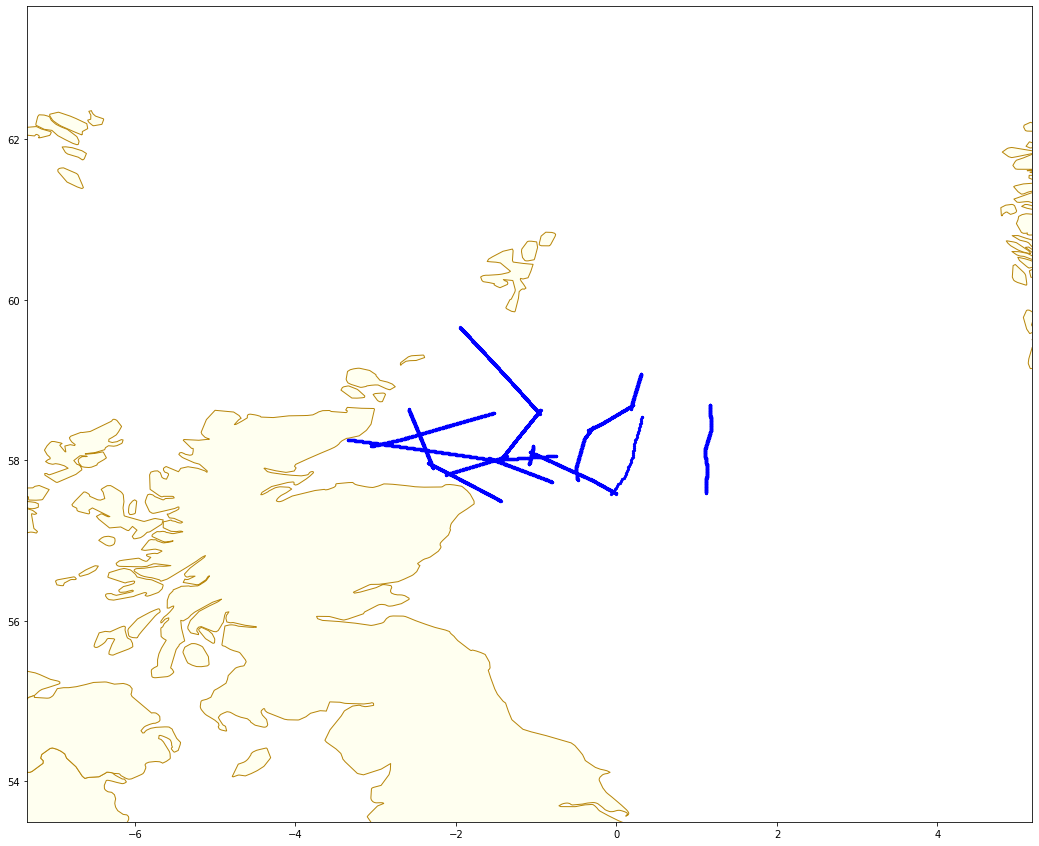

In [120]:
f, ax = plt.subplots(figsize=(20, 15))
# ax.set_aspect('equal')
world.plot(ax=ax, color='ivory', edgecolor='darkgoldenrod')
gdf.plot(ax=ax, marker='o', color='blue', markersize=5);

zoom_var = 4
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-zoom_var, maxx+zoom_var)
ax.set_ylim(miny-zoom_var, maxy+zoom_var)
plt.show()